In [1]:
# NAMA : ADI PRABU JAYANEGARA
# NPM  : 5220411346

# Analisis Teks Komentar YouTube - Perbandingan Dua Skenario
# Dataset: Komentar YouTube Berbahasa Indonesia

# ============================================================================
# INSTALASI DAN IMPORT LIBRARY
# ============================================================================

In [2]:
# !pip install pandas numpy matplotlib seaborn scikit-learn sastrawi nltk wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Text preprocessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [4]:
# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

In [5]:
# Visualization
from wordcloud import WordCloud

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Semua library berhasil diimport")

✓ Semua library berhasil diimport


In [6]:
# ============================================================================
# FUNGSI PREPROCESSING TEKS
# ============================================================================

class IndonesianTextPreprocessor:
    def __init__(self):
        # Inisialisasi Sastrawi
        self.stemmer = StemmerFactory().create_stemmer()
        self.stopword_remover = StopWordRemoverFactory().create_stop_word_remover()
        
    def clean_text(self, text):
        """Membersihkan teks dari URL, emoji, tanda baca, dan angka"""
        if pd.isna(text):
            return ""
        
        # Convert to string
        text = str(text)
        
        # Case folding
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\.\S+', '', text)
        
        # Remove emoji
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def preprocess(self, text):
        """Pipeline lengkap preprocessing"""
        # Clean text
        text = self.clean_text(text)
        
        # Stopword removal
        text = self.stopword_remover.remove(text)
        
        # Stemming
        text = self.stemmer.stem(text)
        
        return text
    
    def preprocess_batch(self, texts):
        """Preprocess batch data"""
        return [self.preprocess(text) for text in texts]

print("✓ Fungsi preprocessing telah didefinisikan")

✓ Fungsi preprocessing telah didefinisikan


In [7]:
# ============================================================================
# FUNGSI CLUSTERING DAN EVALUASI
# ============================================================================

class ClusterAnalyzer:
    def __init__(self, max_clusters=10):
        self.max_clusters = max_clusters
        self.vectorizer = None
        self.kmeans = None
        self.tfidf_matrix = None
        
    def elbow_method(self, tfidf_matrix):
        """Menentukan jumlah cluster optimal dengan Elbow Method"""
        inertias = []
        silhouette_scores = []
        K_range = range(2, self.max_clusters + 1)
        
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(tfidf_matrix)
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(tfidf_matrix, kmeans.labels_))
        
        return list(K_range), inertias, silhouette_scores
    
    def plot_elbow(self, K_range, inertias, silhouette_scores, title="Elbow Method"):
        """Visualisasi Elbow Method"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Inertia plot
        ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
        ax1.set_xlabel('Jumlah Cluster (K)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Inertia', fontsize=12, fontweight='bold')
        ax1.set_title(f'{title} - Inertia', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Silhouette plot
        ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
        ax2.set_xlabel('Jumlah Cluster (K)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
        ax2.set_title(f'{title} - Silhouette Score', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Suggest optimal K
        optimal_k = K_range[np.argmax(silhouette_scores)]
        print(f"\n📊 Jumlah cluster optimal (berdasarkan Silhouette Score): {optimal_k}")
        return optimal_k
    
    def fit_kmeans(self, texts, n_clusters, max_features=1000):
        """Fit K-Means clustering"""
        # TF-IDF Vectorization
        self.vectorizer = TfidfVectorizer(max_features=max_features, min_df=2, max_df=0.8)
        self.tfidf_matrix = self.vectorizer.fit_transform(texts)
        
        # K-Means clustering
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = self.kmeans.fit_predict(self.tfidf_matrix)
        
        return labels
    
    def get_top_terms_per_cluster(self, n_terms=10):
        """Ekstraksi kata dominan per cluster (Topic Modeling)"""
        order_centroids = self.kmeans.cluster_centers_.argsort()[:, ::-1]
        terms = self.vectorizer.get_feature_names_out()
        
        cluster_topics = {}
        for i in range(self.kmeans.n_clusters):
            top_terms = [terms[ind] for ind in order_centroids[i, :n_terms]]
            cluster_topics[i] = top_terms
        
        return cluster_topics
    
    def evaluate_clustering(self, tfidf_matrix, labels):
        """Evaluasi kualitas clustering"""
        silhouette = silhouette_score(tfidf_matrix, labels)
        davies_bouldin = davies_bouldin_score(tfidf_matrix.toarray(), labels)
        calinski_harabasz = calinski_harabasz_score(tfidf_matrix.toarray(), labels)
        
        metrics = {
            'Silhouette Score': silhouette,
            'Davies-Bouldin Index': davies_bouldin,
            'Calinski-Harabasz Index': calinski_harabasz
        }
        
        return metrics
    
    def visualize_clusters(self, tfidf_matrix, labels, title="Cluster Visualization"):
        """Visualisasi cluster dengan PCA"""
        pca = PCA(n_components=2, random_state=42)
        reduced_data = pca.fit_transform(tfidf_matrix.toarray())
        
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], 
                            c=labels, cmap='viridis', alpha=0.6, s=50)
        plt.colorbar(scatter, label='Cluster')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', 
                   fontsize=12, fontweight='bold')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', 
                   fontsize=12, fontweight='bold')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

print("✓ Fungsi clustering dan evaluasi telah didefinisikan")

✓ Fungsi clustering dan evaluasi telah didefinisikan


In [8]:
# ============================================================================
# FUNGSI VISUALISASI
# ============================================================================

def plot_cluster_distribution(labels, title="Distribusi Cluster"):
    """Visualisasi distribusi data per cluster"""
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    cluster_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Cluster', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Jumlah Komentar', fontsize=12, fontweight='bold')
    ax1.set_title(f'{title} - Bar Chart', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Pie chart
    ax2.pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index],
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette("husl", len(cluster_counts)))
    ax2.set_title(f'{title} - Pie Chart', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def generate_wordcloud(texts, title="Word Cloud"):
    """Generate word cloud dari teks"""
    text_combined = ' '.join(texts)
    
    wordcloud = WordCloud(width=1200, height=600, 
                         background_color='white',
                         colormap='viridis',
                         max_words=100).generate(text_combined)
    
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def plot_topic_comparison(scenario1_topics, scenario2_topics):
    """Membandingkan topik dari kedua skenario"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scenario 1
    s1_data = pd.DataFrame([
        {'Cluster': f'C{k}', 'Terms': ', '.join(v[:5])} 
        for k, v in scenario1_topics.items()
    ])
    axes[0].axis('tight')
    axes[0].axis('off')
    table1 = axes[0].table(cellText=s1_data.values, colLabels=s1_data.columns,
                          cellLoc='left', loc='center', colWidths=[0.15, 0.85])
    table1.auto_set_font_size(False)
    table1.set_fontsize(9)
    table1.scale(1, 2)
    axes[0].set_title('Skenario 1: Tanpa Pemisahan Sentimen', 
                     fontsize=12, fontweight='bold', pad=20)
    
    # Scenario 2
    s2_text = "Topik per Sentimen:\n\n"
    for sentiment, topics in scenario2_topics.items():
        s2_text += f"{sentiment.upper()}:\n"
        for cluster, terms in topics.items():
            s2_text += f"  Cluster {cluster}: {', '.join(terms[:5])}\n"
        s2_text += "\n"
    
    axes[1].text(0.1, 0.5, s2_text, fontsize=9, verticalalignment='center',
                family='monospace', transform=axes[1].transAxes)
    axes[1].axis('off')
    axes[1].set_title('Skenario 2: Dengan Pemisahan Sentimen', 
                     fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

print("✓ Fungsi visualisasi telah didefinisikan")

✓ Fungsi visualisasi telah didefinisikan


In [10]:
# ============================================================================
# LOAD DATA
# ============================================================================

print("\n" + "="*80)
print("📂 MEMUAT DATASET")
print("="*80)

# Load dataset utama
try:
    df_main = pd.read_csv('youtube_comments.csv')
    print(f"✓ Dataset utama dimuat: {len(df_main)} komentar")
    print(f"  Kolom: {df_main.columns.tolist()}")
except Exception as e:
    print(f"❌ Error memuat dataset utama: {e}")
    df_main = None

# Load dataset sentimen
try:
    df_negative = pd.read_csv('komentar_negatif.csv')
    df_positive = pd.read_csv('komentar_positif.csv')
    df_neutral = pd.read_csv('komentar_netral.csv')
    print(f"✓ Dataset sentimen dimuat:")
    print(f"  - Negatif: {len(df_negative)} komentar")
    print(f"  - Positif: {len(df_positive)} komentar")
    print(f"  - Netral: {len(df_neutral)} komentar")
except Exception as e:
    print(f"❌ Error memuat dataset sentimen: {e}")
    df_negative = df_positive = df_neutral = None


📂 MEMUAT DATASET
✓ Dataset utama dimuat: 2157 komentar
  Kolom: ['comment']
✓ Dataset sentimen dimuat:
  - Negatif: 150 komentar
  - Positif: 150 komentar
  - Netral: 50 komentar



🔬 SKENARIO 1: ANALISIS TANPA PEMISAHAN SENTIMEN

1️⃣ Preprocessing Teks...
✓ Preprocessing selesai. Data valid: 2157 komentar

📝 Sample data setelah preprocessing:
                                             comment  \
0  hacker lapang males patroli malam pagi foto em...   
1              perintah bjorka tangkap bjorka typing   
2  indonesia kurang orang pinter kurang orang juj...   

                                       comment_clean  
0  hacker lapang males patroli malam pagi foto em...  
1              perintah bjorka tangkap bjorka typing  
2  indonesia kurang orang pinter kurang orang juj...  

2️⃣ Analisis Clustering...
   Menjalankan Elbow Method...


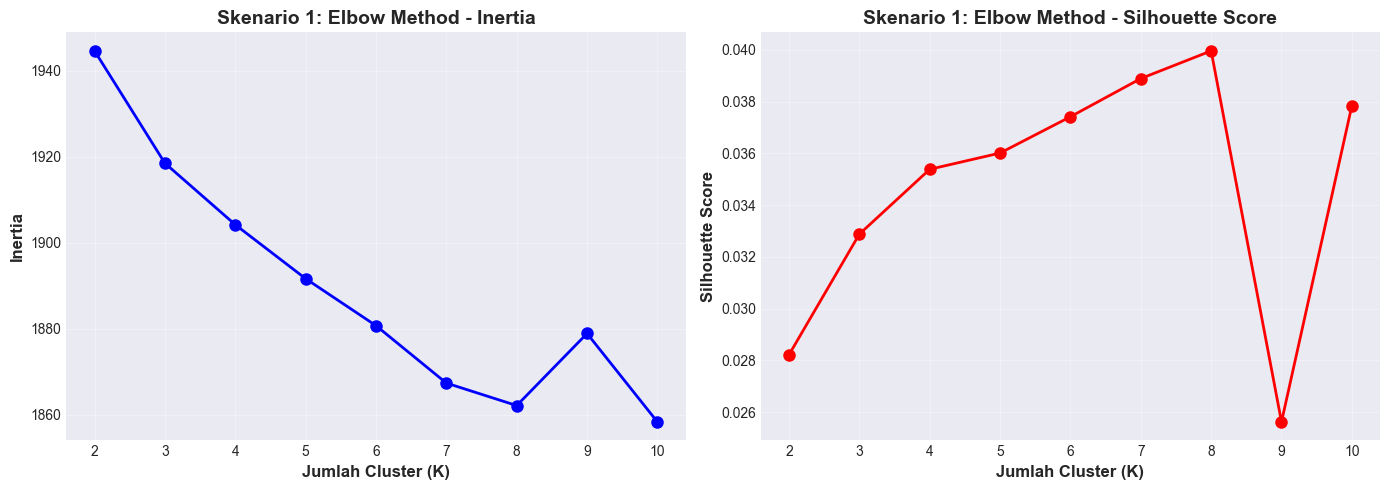


📊 Jumlah cluster optimal (berdasarkan Silhouette Score): 8

3️⃣ Menjalankan K-Means dengan K=8...

4️⃣ Ekstraksi Topik per Cluster...

📊 TOPIK DOMINAN PER CLUSTER (Skenario 1):
--------------------------------------------------------------------------------

Cluster 0 (40 komentar):
  Kata kunci: fakta, terang, polisi, cerdas, mobil, sim, pelan, buset, ngk, konoha

Cluster 1 (1409 komentar):
  Kata kunci: orang, bang, hacker, bener, anak, tau, indonesia, kerja, perintah, ded

Cluster 2 (169 komentar):
  Kata kunci: polisi, kerja, konoha, nangkep, tidur, bjorka, lapor, hilang, tau, orang

Cluster 3 (80 komentar):
  Kata kunci: tangkap, salah, bjorka, polisi, hacker, tau, byorka, gua, lucu, keren

Cluster 4 (181 komentar):
  Kata kunci: bjorka, nangkep, asli, ketangkep, nonton, orang, percaya, muncul, perintah, rakyat

Cluster 5 (62 komentar):
  Kata kunci: nangkap, ketawa, bjorka, polisi, hacker, maling, liat, sok, ken, motor

Cluster 6 (73 komentar):
  Kata kunci: judol, bandar, nangk

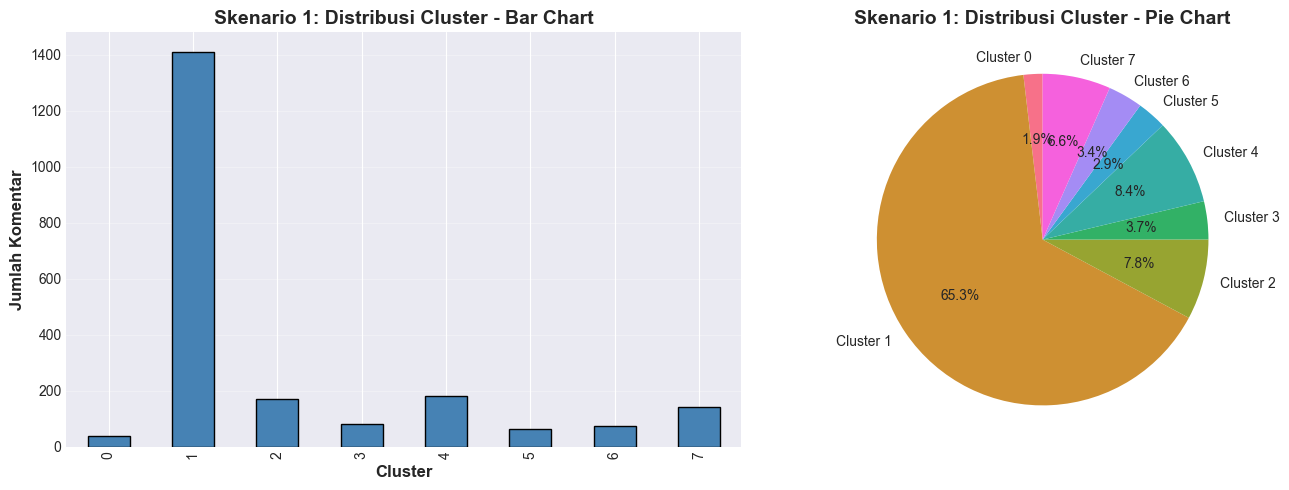

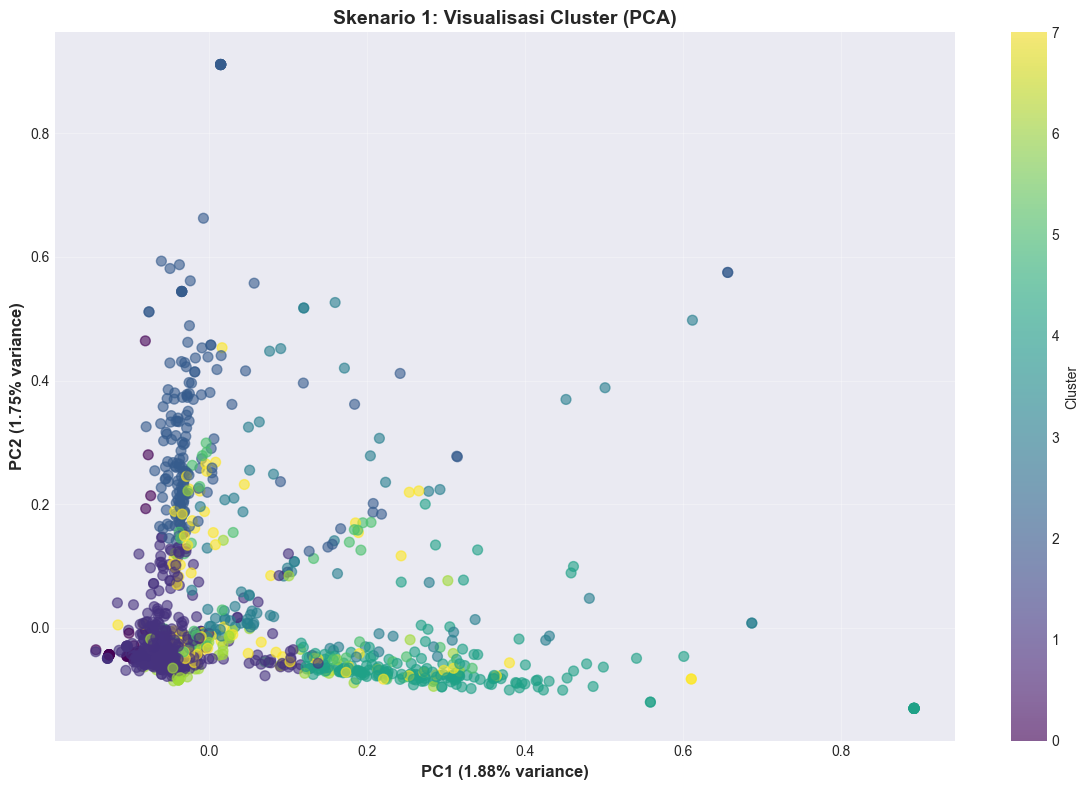

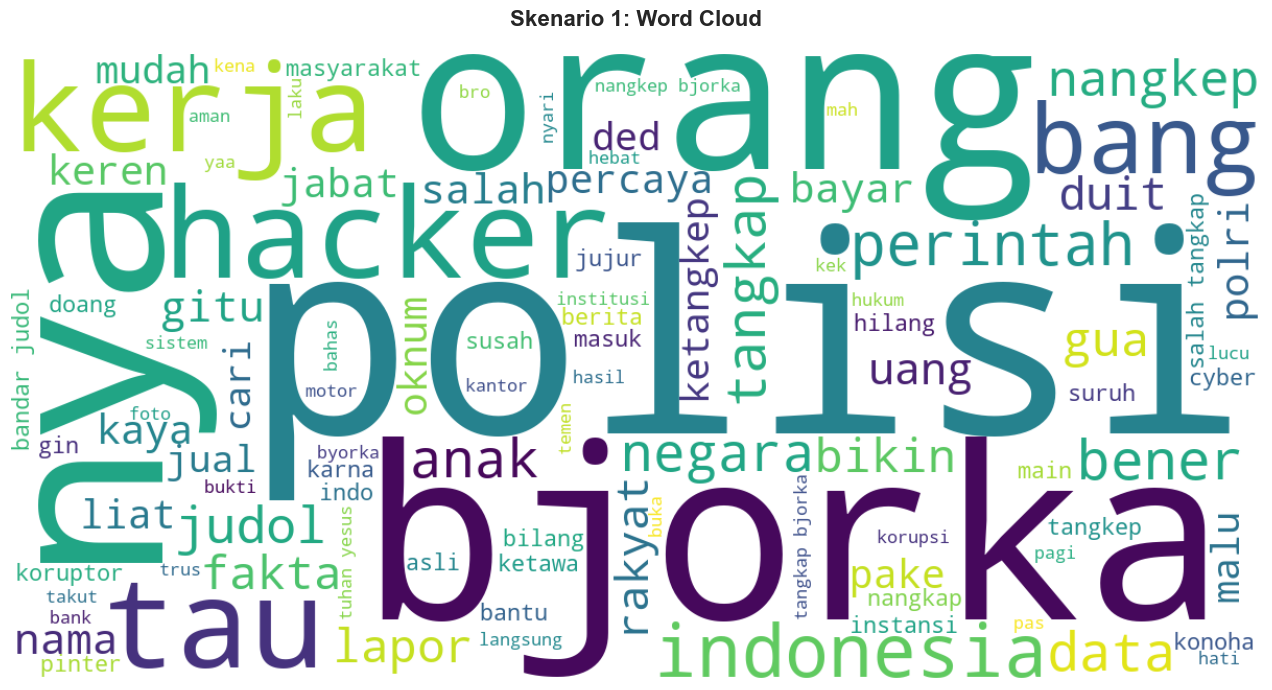

In [11]:
# ============================================================================
# SKENARIO 1: TANPA PEMISAHAN SENTIMEN
# ============================================================================

print("\n" + "="*80)
print("🔬 SKENARIO 1: ANALISIS TANPA PEMISAHAN SENTIMEN")
print("="*80)

if df_main is not None:
    # Preprocessing
    print("\n1️⃣ Preprocessing Teks...")
    preprocessor = IndonesianTextPreprocessor()
    df_main['comment_clean'] = preprocessor.preprocess_batch(df_main['comment'].tolist())
    
    # Remove empty texts
    df_main = df_main[df_main['comment_clean'].str.len() > 0].reset_index(drop=True)
    print(f"✓ Preprocessing selesai. Data valid: {len(df_main)} komentar")
    
    # Display sample
    print("\n📝 Sample data setelah preprocessing:")
    print(df_main[['comment', 'comment_clean']].head(3))
    
    # Clustering
    print("\n2️⃣ Analisis Clustering...")
    analyzer1 = ClusterAnalyzer(max_clusters=10)
    
    # Elbow method
    print("   Menjalankan Elbow Method...")
    K_range, inertias, silhouette_scores = analyzer1.elbow_method(
        analyzer1.vectorizer.fit_transform(df_main['comment_clean']) if analyzer1.vectorizer else 
        TfidfVectorizer(max_features=1000).fit_transform(df_main['comment_clean'])
    )
    optimal_k1 = analyzer1.plot_elbow(K_range, inertias, silhouette_scores, 
                                      "Skenario 1: Elbow Method")
    
    # Fit K-Means with optimal K
    print(f"\n3️⃣ Menjalankan K-Means dengan K={optimal_k1}...")
    labels1 = analyzer1.fit_kmeans(df_main['comment_clean'], n_clusters=optimal_k1)
    df_main['cluster'] = labels1
    
    # Topic modeling
    print("\n4️⃣ Ekstraksi Topik per Cluster...")
    topics1 = analyzer1.get_top_terms_per_cluster(n_terms=10)
    
    print("\n📊 TOPIK DOMINAN PER CLUSTER (Skenario 1):")
    print("-" * 80)
    for cluster_id, terms in topics1.items():
        print(f"\nCluster {cluster_id} ({sum(labels1 == cluster_id)} komentar):")
        print(f"  Kata kunci: {', '.join(terms)}")
    
    # Evaluation
    print("\n5️⃣ Evaluasi Clustering...")
    metrics1 = analyzer1.evaluate_clustering(analyzer1.tfidf_matrix, labels1)
    print("\n📈 METRIK EVALUASI (Skenario 1):")
    for metric, value in metrics1.items():
        print(f"  {metric}: {value:.4f}")
    
    # Visualizations
    print("\n6️⃣ Generating Visualizations...")
    plot_cluster_distribution(labels1, "Skenario 1: Distribusi Cluster")
    analyzer1.visualize_clusters(analyzer1.tfidf_matrix, labels1, 
                                "Skenario 1: Visualisasi Cluster (PCA)")
    generate_wordcloud(df_main['comment_clean'], "Skenario 1: Word Cloud")
    
    scenario1_results = {
        'data': df_main,
        'labels': labels1,
        'topics': topics1,
        'metrics': metrics1,
        'analyzer': analyzer1
    }
else:
    print("⚠️ Skenario 1 dilewati karena dataset tidak tersedia")
    scenario1_results = None


🔬 SKENARIO 2: ANALISIS DENGAN PEMISAHAN SENTIMEN

📊 Analisis Sentimen: NEGATIF

1️⃣ Preprocessing teks negatif...
✓ Data valid: 150 komentar

2️⃣ Analisis Clustering negatif...


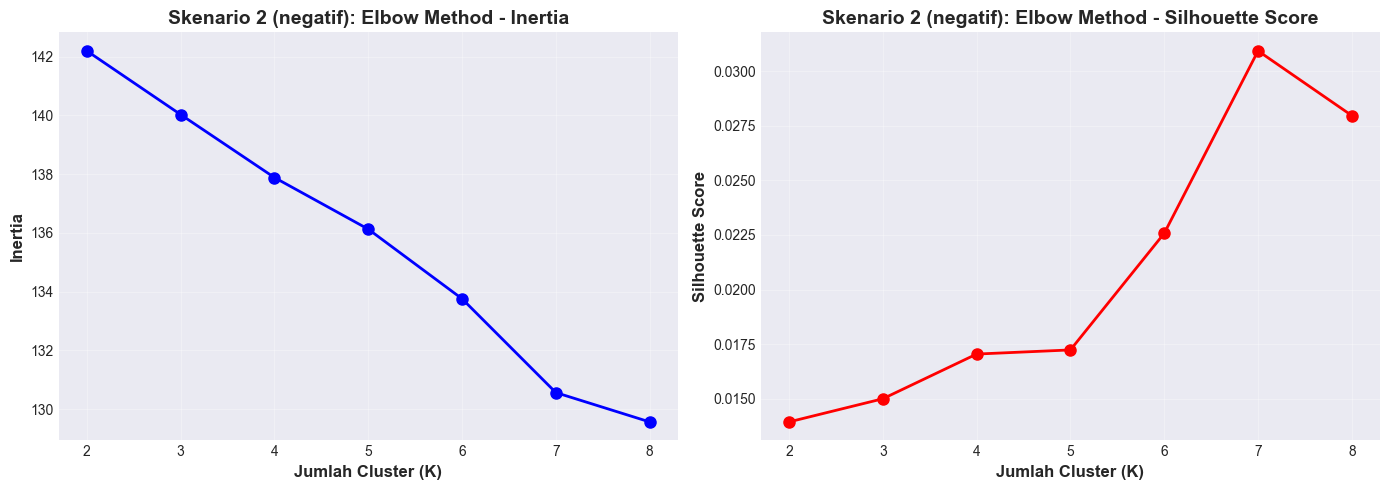


📊 Jumlah cluster optimal (berdasarkan Silhouette Score): 7

3️⃣ Menjalankan K-Means dengan K=7...

4️⃣ Ekstraksi Topik per Cluster...

📊 TOPIK DOMINAN PER CLUSTER (NEGATIF):
--------------------------------------------------------------------------------

Cluster 0 (7 komentar):
  Kata kunci: salah, perintah, polisi, laku, lurah, negeri, anak, keluarga, tangkap, tunjuk

Cluster 1 (20 komentar):
  Kata kunci: orang, kerja, polisi, indonesia, jujur, kurang, fto, anak, masyarakat, sekolah

Cluster 2 (16 komentar):
  Kata kunci: hilang, lapor, motor, polisi, maling, temen, nya, surat, urus, uang

Cluster 3 (20 komentar):
  Kata kunci: polisi, pagi, liat, pas, foto, empat, tidur, bener, gitu, minimal

Cluster 4 (65 komentar):
  Kata kunci: bener, game, bang, suka, baca, bayar, nya, gua, nyata, kaya

Cluster 5 (11 komentar):
  Kata kunci: bjorka, judol, bandar, alas, tangkep, akun, tangkap, ketawa, mata, rakyat

Cluster 6 (11 komentar):
  Kata kunci: fakta, terang, pelan, hukum, maju, sesua

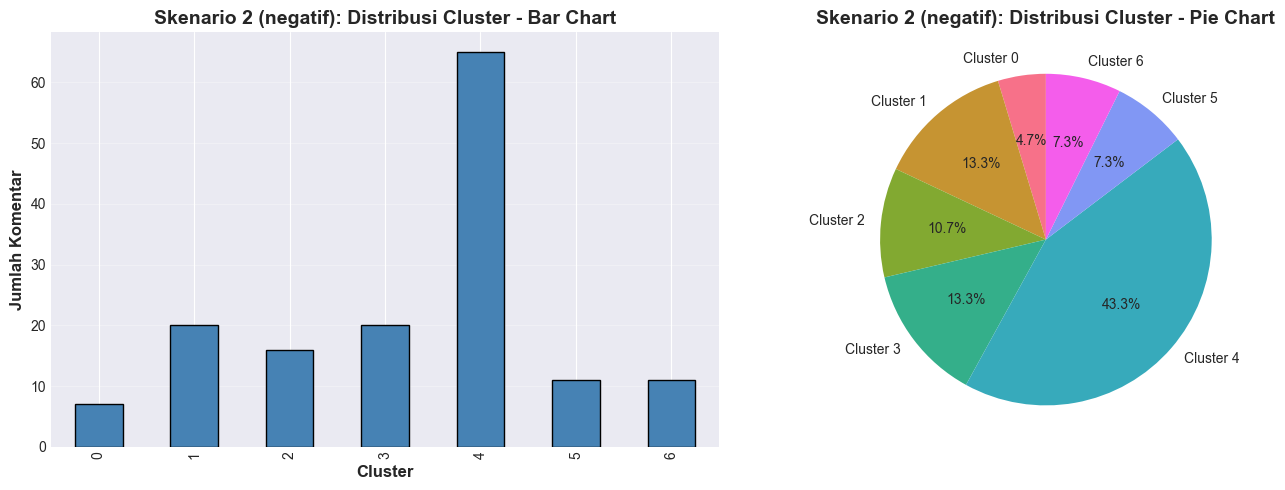

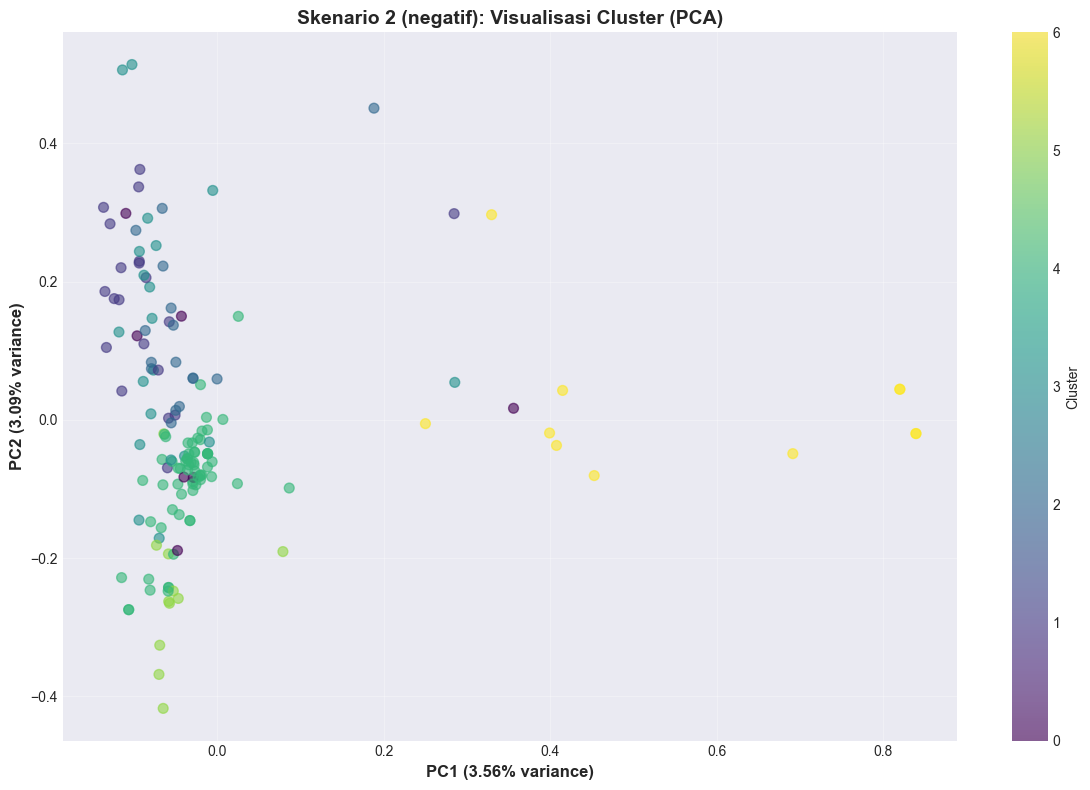

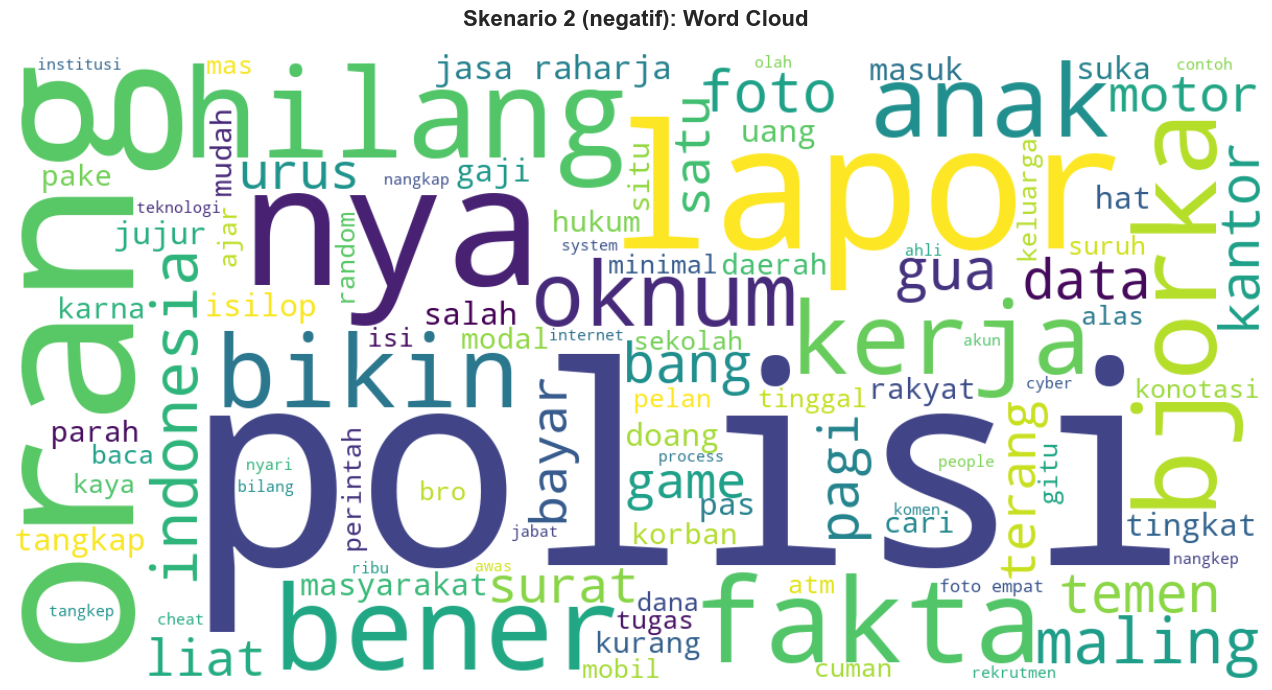


📊 Analisis Sentimen: POSITIF

1️⃣ Preprocessing teks positif...
✓ Data valid: 150 komentar

2️⃣ Analisis Clustering positif...


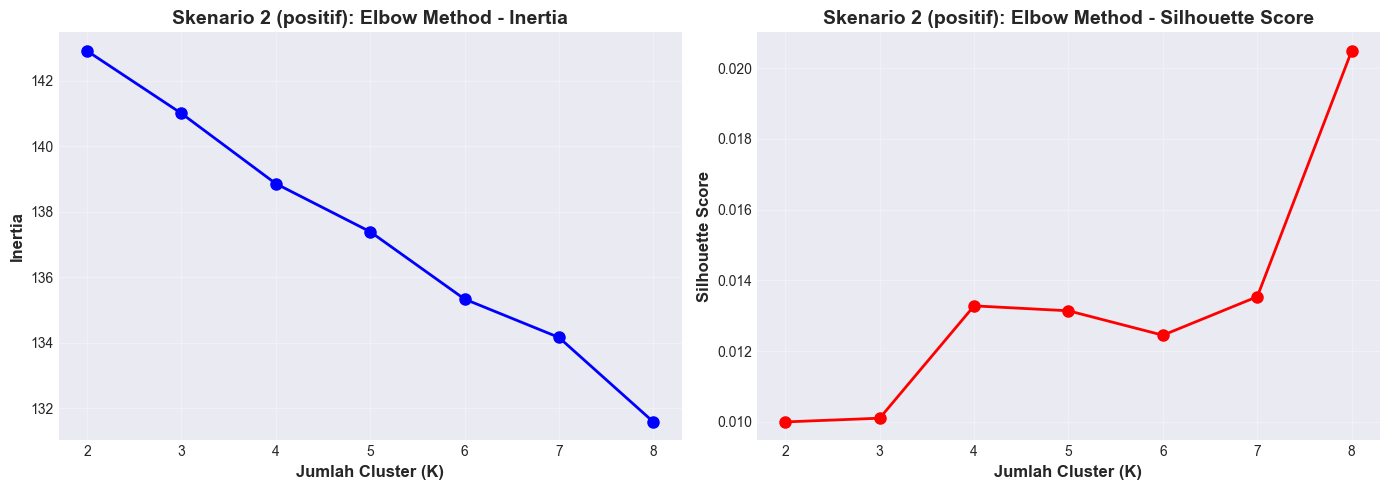


📊 Jumlah cluster optimal (berdasarkan Silhouette Score): 8

3️⃣ Menjalankan K-Means dengan K=8...

4️⃣ Ekstraksi Topik per Cluster...

📊 TOPIK DOMINAN PER CLUSTER (POSITIF):
--------------------------------------------------------------------------------

Cluster 0 (6 komentar):
  Kata kunci: duit, dpt, doang, data, koruptor, ketangkep, ngak, tangkap, bang, main

Cluster 1 (9 komentar):
  Kata kunci: judol, main, bandar, pinter, tangkap, aneh, indo, nangkap, rugi, keren

Cluster 2 (13 komentar):
  Kata kunci: bjorka, gua, you, nangkap, rakyat, alive, asli, nya, keinget, berita

Cluster 3 (15 komentar):
  Kata kunci: anak, indonesia, normal, cerdas, pintar, hacker, komunitas, saran, pola, cipta

Cluster 4 (5 komentar):
  Kata kunci: bahasa, mas, kuping, bilang, tutup, teguh, top, lapor, data, better

Cluster 5 (18 komentar):
  Kata kunci: polisi, bener, hahaha, tidur, prestasi, anjir, bayar, nya, nangkap, data

Cluster 6 (54 komentar):
  Kata kunci: hacker, bikin, system, real, foto, v

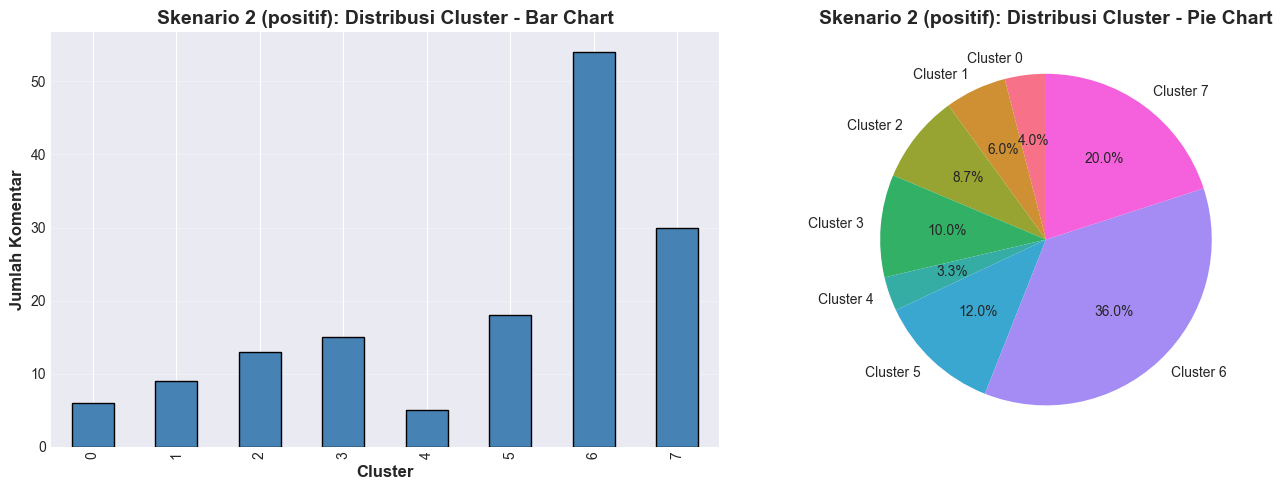

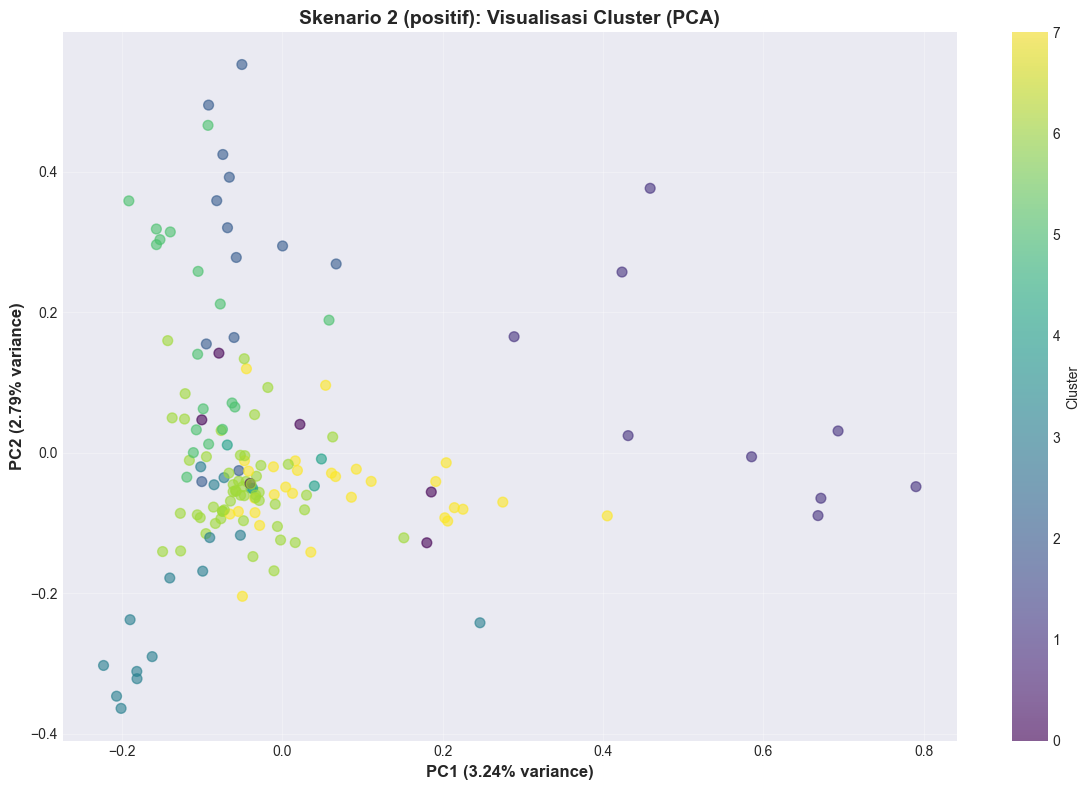

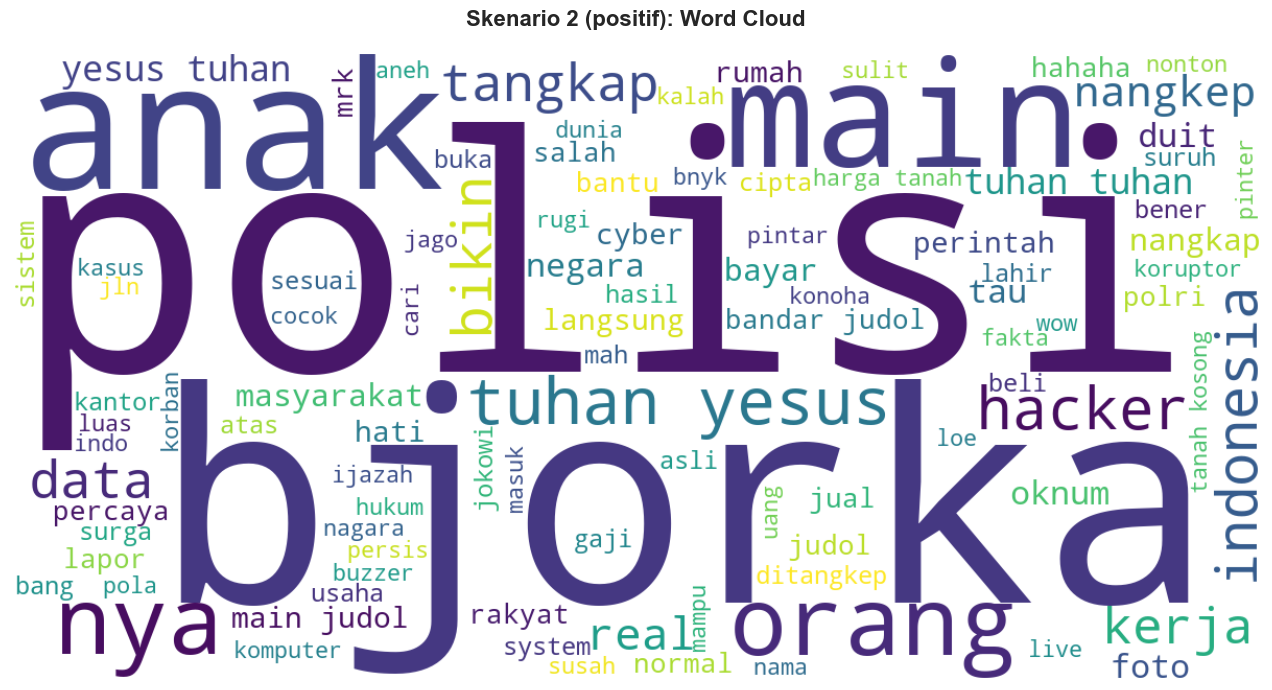


📊 Analisis Sentimen: NETRAL

1️⃣ Preprocessing teks netral...
✓ Data valid: 50 komentar

2️⃣ Analisis Clustering netral...


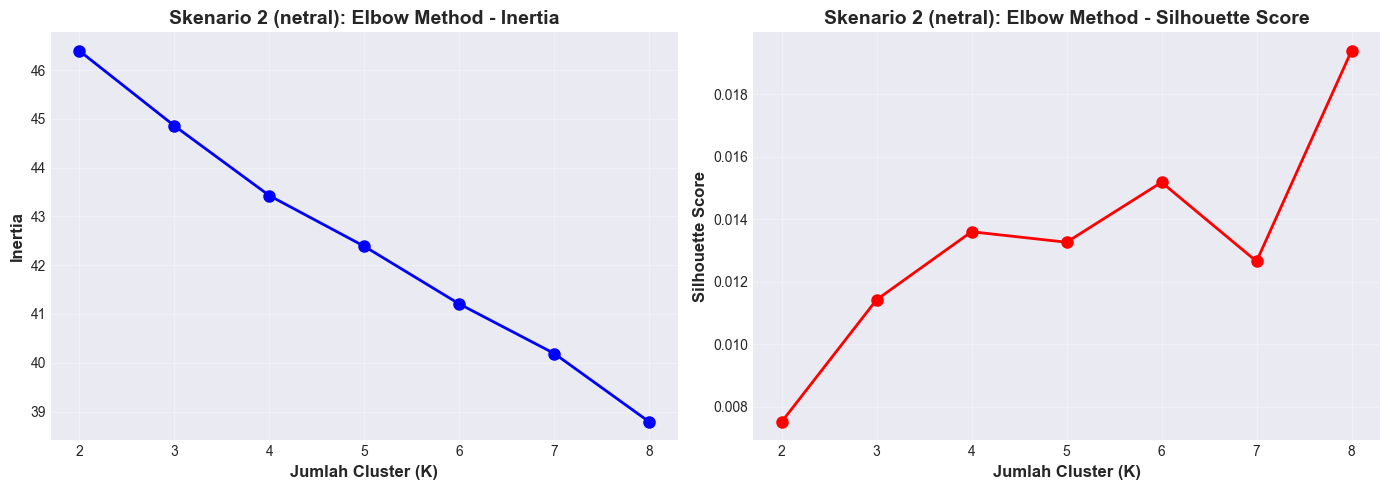


📊 Jumlah cluster optimal (berdasarkan Silhouette Score): 8

3️⃣ Menjalankan K-Means dengan K=8...

4️⃣ Ekstraksi Topik per Cluster...

📊 TOPIK DOMINAN PER CLUSTER (NETRAL):
--------------------------------------------------------------------------------

Cluster 0 (9 komentar):
  Kata kunci: bang, kertas, lapor, doang, negeri, bener, gitu, pagi, kek, sampe

Cluster 1 (7 komentar):
  Kata kunci: polisi, tau, lulus, uang, rakyat, orang, citra, kerja, bener, smk

Cluster 2 (4 komentar):
  Kata kunci: fakta, polisi, aparat, ngurus, dasar, malak, habis, polri, negara, yaa

Cluster 3 (3 komentar):
  Kata kunci: nya, bjorka, bobrok, yaa, usaha, uang, suruh, smk, tempat, trus

Cluster 4 (11 komentar):
  Kata kunci: indonesia, emng, tempat, uang, yaa, polri, laku, oknum, bilang, dasar

Cluster 5 (5 komentar):
  Kata kunci: foto, pergi, hasil, polisi, lapor, bener, smk, trus, anjir, lapang

Cluster 6 (8 komentar):
  Kata kunci: gua, bayar, motor, perintah, pas, rumah, rakyat, mobil, hacker, neg

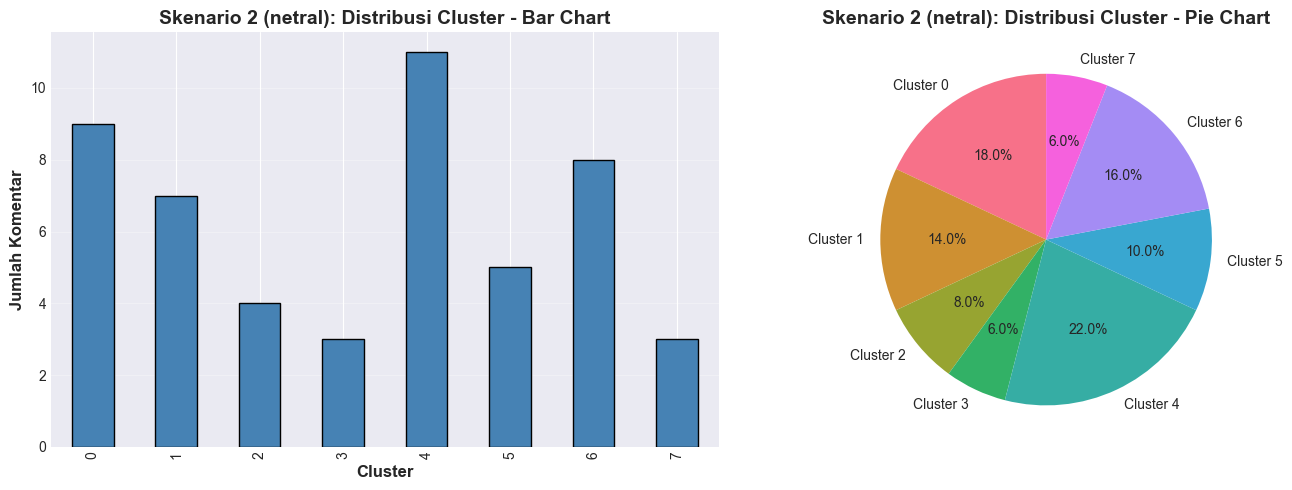

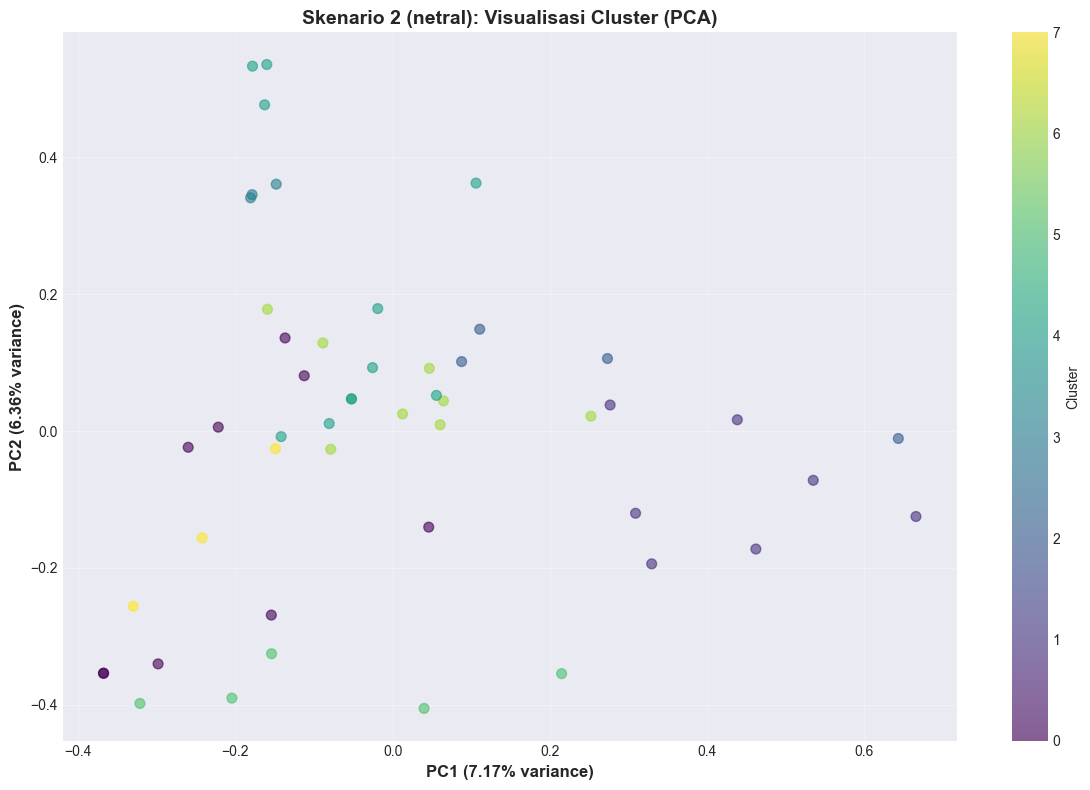

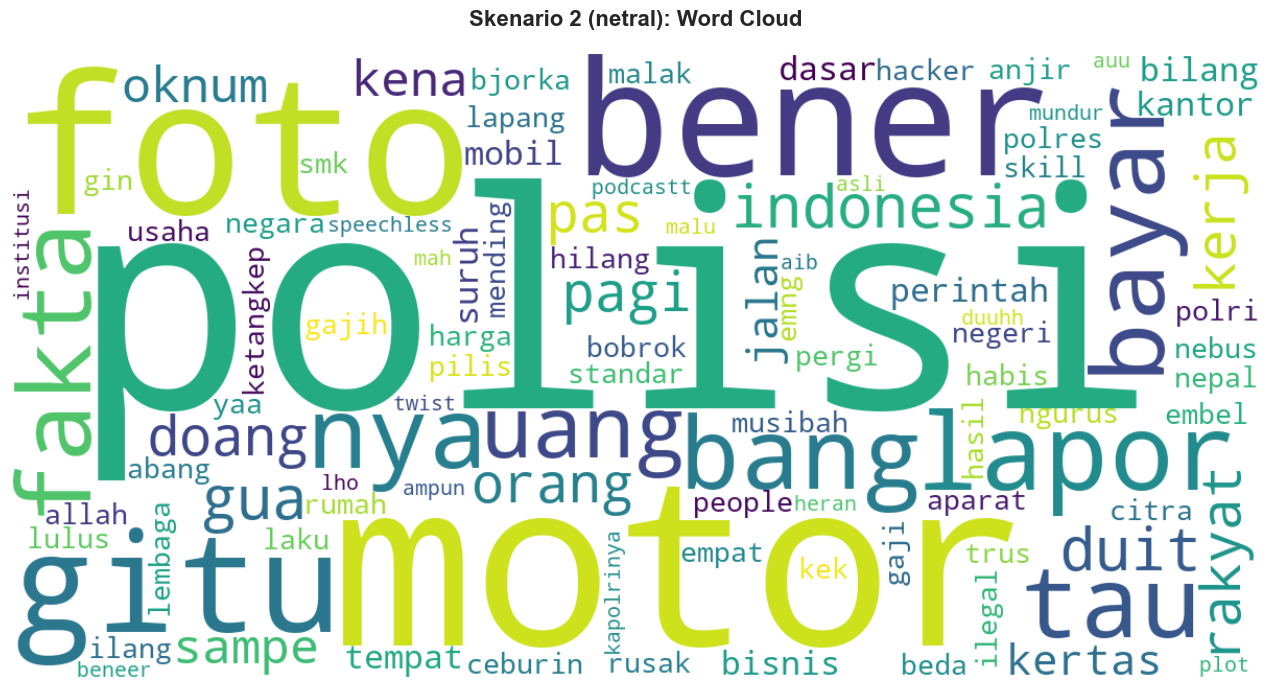

In [12]:
# ============================================================================
# SKENARIO 2: DENGAN PEMISAHAN SENTIMEN
# ============================================================================

print("\n" + "="*80)
print("🔬 SKENARIO 2: ANALISIS DENGAN PEMISAHAN SENTIMEN")
print("="*80)

if all(df is not None for df in [df_negative, df_positive, df_neutral]):
    scenario2_results = {}
    
    sentiments = {
        'negatif': df_negative,
        'positif': df_positive,
        'netral': df_neutral
    }
    
    preprocessor2 = IndonesianTextPreprocessor()
    
    for sentiment_name, df_sentiment in sentiments.items():
        print(f"\n{'='*80}")
        print(f"📊 Analisis Sentimen: {sentiment_name.upper()}")
        print(f"{'='*80}")
        
        # Preprocessing
        print(f"\n1️⃣ Preprocessing teks {sentiment_name}...")
        
        # Get column name (handle different possibilities)
        col_name = 'comment' if 'comment' in df_sentiment.columns else df_sentiment.columns[0]
        
        df_sentiment['comment_clean'] = preprocessor2.preprocess_batch(
            df_sentiment[col_name].tolist()
        )
        df_sentiment = df_sentiment[df_sentiment['comment_clean'].str.len() > 0].reset_index(drop=True)
        print(f"✓ Data valid: {len(df_sentiment)} komentar")
        
        if len(df_sentiment) < 10:
            print(f"⚠️ Data {sentiment_name} terlalu sedikit, dilewati")
            continue
        
        # Clustering
        print(f"\n2️⃣ Analisis Clustering {sentiment_name}...")
        analyzer2 = ClusterAnalyzer(max_clusters=min(8, len(df_sentiment)//2))
        
        # Elbow method
        K_range, inertias, silhouette_scores = analyzer2.elbow_method(
            TfidfVectorizer(max_features=500).fit_transform(df_sentiment['comment_clean'])
        )
        optimal_k2 = analyzer2.plot_elbow(K_range, inertias, silhouette_scores,
                                         f"Skenario 2 ({sentiment_name}): Elbow Method")
        
        # Fit K-Means
        print(f"\n3️⃣ Menjalankan K-Means dengan K={optimal_k2}...")
        labels2 = analyzer2.fit_kmeans(df_sentiment['comment_clean'], 
                                       n_clusters=optimal_k2, max_features=500)
        df_sentiment['cluster'] = labels2
        
        # Topic modeling
        print(f"\n4️⃣ Ekstraksi Topik per Cluster...")
        topics2 = analyzer2.get_top_terms_per_cluster(n_terms=10)
        
        print(f"\n📊 TOPIK DOMINAN PER CLUSTER ({sentiment_name.upper()}):")
        print("-" * 80)
        for cluster_id, terms in topics2.items():
            print(f"\nCluster {cluster_id} ({sum(labels2 == cluster_id)} komentar):")
            print(f"  Kata kunci: {', '.join(terms)}")
        
        # Evaluation
        metrics2 = analyzer2.evaluate_clustering(analyzer2.tfidf_matrix, labels2)
        print(f"\n📈 METRIK EVALUASI ({sentiment_name.upper()}):")
        for metric, value in metrics2.items():
            print(f"  {metric}: {value:.4f}")
        
        # Visualizations
        plot_cluster_distribution(labels2, f"Skenario 2 ({sentiment_name}): Distribusi Cluster")
        analyzer2.visualize_clusters(analyzer2.tfidf_matrix, labels2,
                                    f"Skenario 2 ({sentiment_name}): Visualisasi Cluster (PCA)")
        generate_wordcloud(df_sentiment['comment_clean'], 
                          f"Skenario 2 ({sentiment_name}): Word Cloud")
        
        # Store results
        scenario2_results[sentiment_name] = {
            'data': df_sentiment,
            'labels': labels2,
            'topics': topics2,
            'metrics': metrics2,
            'analyzer': analyzer2
        }
else:
    print("⚠️ Skenario 2 dilewati karena dataset sentimen tidak lengkap")
    scenario2_results = None


📊 PERBANDINGAN HASIL KEDUA SKENARIO

1️⃣ PERBANDINGAN METRIK EVALUASI
--------------------------------------------------------------------------------
                    Skenario  Jumlah Cluster  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index
Skenario 1 (Tanpa Pemisahan)               8          0.041711              4.451084                19.026968
        Skenario 2 (Negatif)               7          0.039081              3.897457                 3.140988
        Skenario 2 (Positif)               8          0.023743              4.161419                 2.576503
         Skenario 2 (Netral)               8          0.072456              2.331922                 2.474391


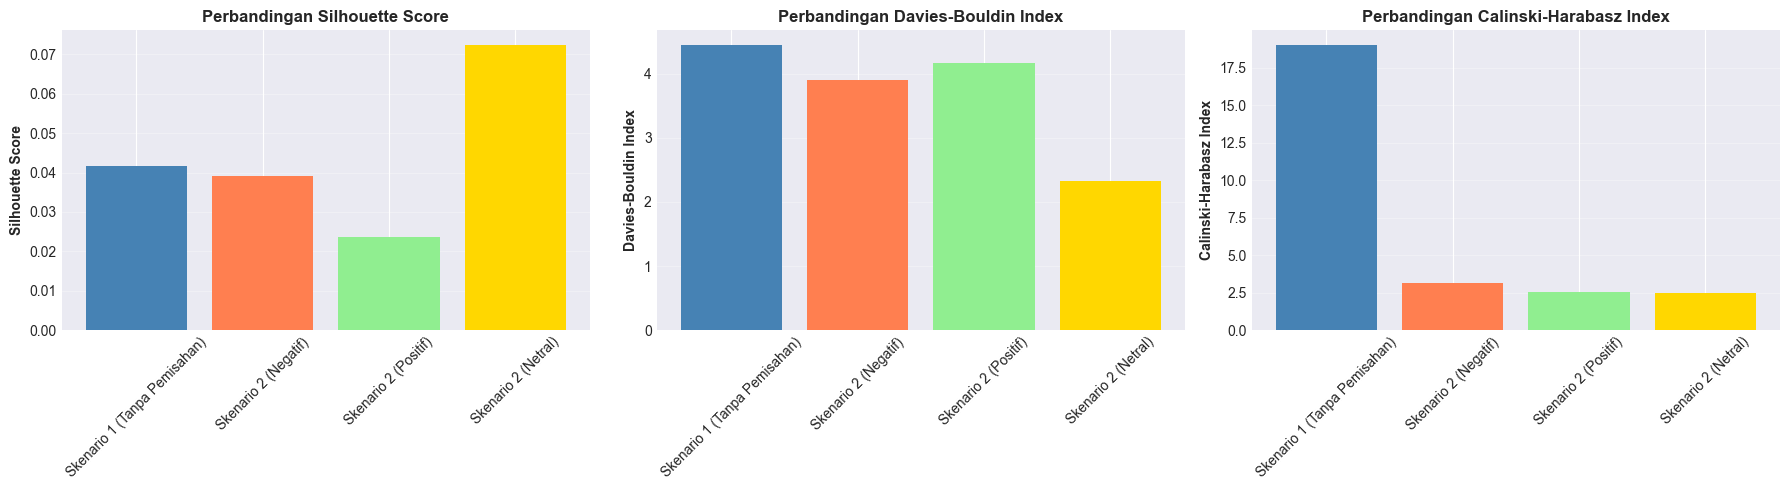


2️⃣ PERBANDINGAN TOPIK
--------------------------------------------------------------------------------


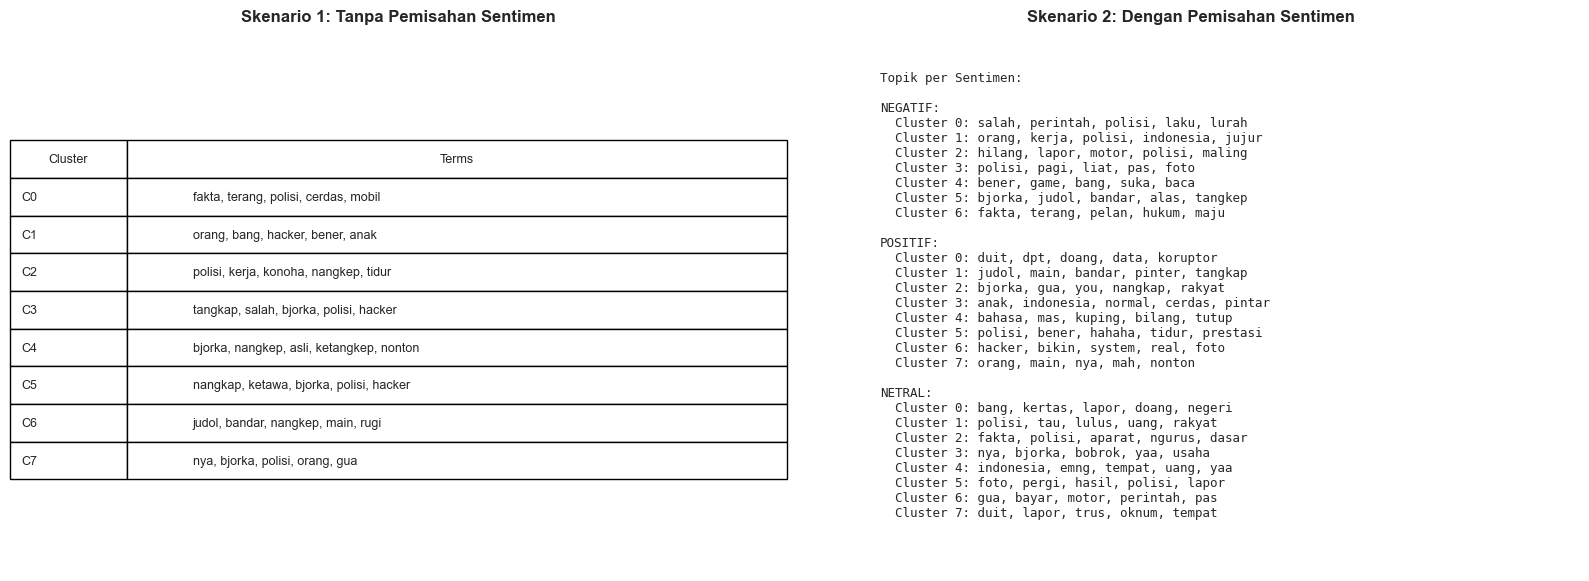


3️⃣ ANALISIS KUALITATIF
--------------------------------------------------------------------------------

    KEJELASAN TOPIK:
    - Skenario 1: Topik lebih umum dan beragam, mencakup berbagai sentimen dalam satu cluster
    - Skenario 2: Topik lebih spesifik dan homogen karena sudah dipisahkan berdasarkan sentimen
    
    HOMOGENITAS CLUSTER:
    - Skenario 1: Cluster cenderung heterogen (campuran sentimen positif, negatif, netral)
    - Skenario 2: Cluster lebih homogen karena sentimen sudah terpisah sebelum clustering
    
    INTERPRETABILITAS HASIL:
    - Skenario 1: Interpretasi lebih menantang karena harus memahami konteks sentimen dalam setiap cluster
    - Skenario 2: Interpretasi lebih mudah karena fokus pada topik dalam sentimen yang sama
    
    KESESUAIAN UNTUK ANALISIS OPINI PUBLIK:
    - Skenario 1: Cocok untuk eksplorasi awal dan menemukan tema umum
    - Skenario 2: Cocok untuk analisis mendalam tentang apa yang disukai/tidak disukai/netral
    
    KOMPLEKSITAS DAN

In [13]:
# ============================================================================
# PERBANDINGAN HASIL
# ============================================================================

print("\n" + "="*80)
print("📊 PERBANDINGAN HASIL KEDUA SKENARIO")
print("="*80)

if scenario1_results and scenario2_results:
    
    # 1. Perbandingan Metrik
    print("\n1️⃣ PERBANDINGAN METRIK EVALUASI")
    print("-" * 80)
    
    comparison_data = []
    
    # Skenario 1
    comparison_data.append({
        'Skenario': 'Skenario 1 (Tanpa Pemisahan)',
        'Jumlah Cluster': len(set(scenario1_results['labels'])),
        'Silhouette Score': scenario1_results['metrics']['Silhouette Score'],
        'Davies-Bouldin Index': scenario1_results['metrics']['Davies-Bouldin Index'],
        'Calinski-Harabasz Index': scenario1_results['metrics']['Calinski-Harabasz Index']
    })
    
    # Skenario 2
    for sentiment, results in scenario2_results.items():
        comparison_data.append({
            'Skenario': f'Skenario 2 ({sentiment.capitalize()})',
            'Jumlah Cluster': len(set(results['labels'])),
            'Silhouette Score': results['metrics']['Silhouette Score'],
            'Davies-Bouldin Index': results['metrics']['Davies-Bouldin Index'],
            'Calinski-Harabasz Index': results['metrics']['Calinski-Harabasz Index']
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))
    
    # Visualisasi perbandingan metrik
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    metrics_to_plot = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']
    
    for idx, metric in enumerate(metrics_to_plot):
        axes[idx].bar(df_comparison['Skenario'], df_comparison[metric], 
                     color=['steelblue', 'coral', 'lightgreen', 'gold'])
        axes[idx].set_title(f'Perbandingan {metric}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(metric, fontsize=10, fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Perbandingan Topik
    print("\n2️⃣ PERBANDINGAN TOPIK")
    print("-" * 80)
    
    s2_topics_dict = {k: v['topics'] for k, v in scenario2_results.items()}
    plot_topic_comparison(scenario1_results['topics'], s2_topics_dict)
    
    # 3. Analisis Kualitatif
    print("\n3️⃣ ANALISIS KUALITATIF")
    print("-" * 80)
    
    print("""
    KEJELASAN TOPIK:
    - Skenario 1: Topik lebih umum dan beragam, mencakup berbagai sentimen dalam satu cluster
    - Skenario 2: Topik lebih spesifik dan homogen karena sudah dipisahkan berdasarkan sentimen
    
    HOMOGENITAS CLUSTER:
    - Skenario 1: Cluster cenderung heterogen (campuran sentimen positif, negatif, netral)
    - Skenario 2: Cluster lebih homogen karena sentimen sudah terpisah sebelum clustering
    
    INTERPRETABILITAS HASIL:
    - Skenario 1: Interpretasi lebih menantang karena harus memahami konteks sentimen dalam setiap cluster
    - Skenario 2: Interpretasi lebih mudah karena fokus pada topik dalam sentimen yang sama
    
    KESESUAIAN UNTUK ANALISIS OPINI PUBLIK:
    - Skenario 1: Cocok untuk eksplorasi awal dan menemukan tema umum
    - Skenario 2: Cocok untuk analisis mendalam tentang apa yang disukai/tidak disukai/netral
    
    KOMPLEKSITAS DAN WAKTU KOMPUTASI:
    - Skenario 1: Lebih sederhana (1 proses clustering)
    - Skenario 2: Lebih kompleks (3 proses clustering terpisah) tetapi memberikan insight lebih detail
    """)
    
    # 4. Kesimpulan
    print("\n4️⃣ KESIMPULAN DAN REKOMENDASI")
    print("="*80)
    
    # Hitung rata-rata Silhouette Score
    s1_silhouette = scenario1_results['metrics']['Silhouette Score']
    s2_silhouettes = [v['metrics']['Silhouette Score'] for v in scenario2_results.values()]
    s2_avg_silhouette = np.mean(s2_silhouettes)
    
    print(f"""
    KESIMPULAN:
    
    1. KUALITAS CLUSTER:
       - Skenario 1 Silhouette Score: {s1_silhouette:.4f}
       - Skenario 2 Rata-rata Silhouette Score: {s2_avg_silhouette:.4f}
       - Pemenang: {'Skenario 2' if s2_avg_silhouette > s1_silhouette else 'Skenario 1'}
    
    2. KEUNGGULAN SKENARIO 1:
       ✓ Proses lebih cepat dan efisien
       ✓ Cocok untuk eksplorasi awal dataset
       ✓ Menemukan tema umum tanpa bias sentimen
       ✓ Implementasi lebih sederhana
    
    3. KEUNGGULAN SKENARIO 2:
       ✓ Cluster lebih homogen dan koheren
       ✓ Topik lebih spesifik dan mudah diinterpretasi
       ✓ Insight lebih mendalam per sentimen
       ✓ Lebih cocok untuk analisis opini publik yang detail
    
    4. REKOMENDASI:
       {'🏆 Gunakan SKENARIO 2 untuk analisis opini publik yang komprehensif' if s2_avg_silhouette > s1_silhouette else '🏆 Gunakan SKENARIO 1 untuk eksplorasi cepat'}
       
       Pendekatan Hybrid: Mulai dengan Skenario 1 untuk overview, lalu gunakan
       Skenario 2 untuk deep dive analisis per sentimen.
    
    5. APLIKASI PRAKTIS:
       - Customer feedback analysis → Skenario 2
       - Social media monitoring → Skenario 2
       - Content recommendation → Skenario 1
       - Trend discovery → Skenario 1
    """)
    
    # 5. Export Results
    print("\n5️⃣ EXPORT HASIL")
    print("-" * 80)
    
    # Save comparison table
    df_comparison.to_csv('comparison_results.csv', index=False)
    print("✓ Tabel perbandingan disimpan: comparison_results.csv")
    
    # Save cluster results - Scenario 1
    scenario1_results['data'][['comment', 'comment_clean', 'cluster']].to_csv(
        'scenario1_clustered_comments.csv', index=False)
    print("✓ Hasil clustering Skenario 1 disimpan: scenario1_clustered_comments.csv")
    
    # Save cluster results - Scenario 2
    for sentiment, results in scenario2_results.items():
        results['data'][['comment_clean', 'cluster']].to_csv(
            f'scenario2_{sentiment}_clustered.csv', index=False)
        print(f"✓ Hasil clustering {sentiment} disimpan: scenario2_{sentiment}_clustered.csv")
    
    # Save topics summary
    with open('topics_summary.txt', 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("RINGKASAN TOPIK - SKENARIO 1\n")
        f.write("="*80 + "\n\n")
        for cluster_id, terms in scenario1_results['topics'].items():
            f.write(f"Cluster {cluster_id}:\n")
            f.write(f"  {', '.join(terms)}\n\n")
        
        f.write("\n" + "="*80 + "\n")
        f.write("RINGKASAN TOPIK - SKENARIO 2\n")
        f.write("="*80 + "\n\n")
        for sentiment, results in scenario2_results.items():
            f.write(f"\n{sentiment.upper()}:\n")
            f.write("-" * 40 + "\n")
            for cluster_id, terms in results['topics'].items():
                f.write(f"  Cluster {cluster_id}: {', '.join(terms)}\n")
    
    print("✓ Ringkasan topik disimpan: topics_summary.txt")
    
    print("\n✅ Semua hasil berhasil diekspor!")

else:
    print("⚠️ Perbandingan tidak dapat dilakukan karena salah satu skenario gagal")

In [14]:
# ============================================================================
# ANALISIS TAMBAHAN (OPSIONAL)
# ============================================================================

print("\n" + "="*80)
print("📈 ANALISIS TAMBAHAN")
print("="*80)

if scenario1_results:
    print("\n🔍 STATISTIK DESKRIPTIF SKENARIO 1:")
    print("-" * 80)
    print(f"Total komentar: {len(scenario1_results['data'])}")
    print(f"Jumlah cluster: {len(scenario1_results['topics'])}")
    print(f"Rata-rata panjang komentar: {scenario1_results['data']['comment'].str.len().mean():.2f} karakter")
    print(f"Rata-rata kata per komentar: {scenario1_results['data']['comment_clean'].str.split().str.len().mean():.2f} kata")
    
    # Cluster size distribution
    cluster_sizes = pd.Series(scenario1_results['labels']).value_counts().sort_index()
    print(f"\nDistribusi ukuran cluster:")
    for cluster_id, size in cluster_sizes.items():
        percentage = (size / len(scenario1_results['labels'])) * 100
        print(f"  Cluster {cluster_id}: {size} komentar ({percentage:.1f}%)")

if scenario2_results:
    print("\n🔍 STATISTIK DESKRIPTIF SKENARIO 2:")
    print("-" * 80)
    for sentiment, results in scenario2_results.items():
        print(f"\n{sentiment.upper()}:")
        print(f"  Total komentar: {len(results['data'])}")
        print(f"  Jumlah cluster: {len(results['topics'])}")
        print(f"  Rata-rata kata per komentar: {results['data']['comment_clean'].str.split().str.len().mean():.2f} kata")

print("\n" + "="*80)
print("✅ ANALISIS SELESAI")


📈 ANALISIS TAMBAHAN

🔍 STATISTIK DESKRIPTIF SKENARIO 1:
--------------------------------------------------------------------------------
Total komentar: 2157
Jumlah cluster: 8
Rata-rata panjang komentar: 46.67 karakter
Rata-rata kata per komentar: 7.29 kata

Distribusi ukuran cluster:
  Cluster 0: 40 komentar (1.9%)
  Cluster 1: 1409 komentar (65.3%)
  Cluster 2: 169 komentar (7.8%)
  Cluster 3: 80 komentar (3.7%)
  Cluster 4: 181 komentar (8.4%)
  Cluster 5: 62 komentar (2.9%)
  Cluster 6: 73 komentar (3.4%)
  Cluster 7: 143 komentar (6.6%)

🔍 STATISTIK DESKRIPTIF SKENARIO 2:
--------------------------------------------------------------------------------

NEGATIF:
  Total komentar: 150
  Jumlah cluster: 7
  Rata-rata kata per komentar: 11.10 kata

POSITIF:
  Total komentar: 150
  Jumlah cluster: 8
  Rata-rata kata per komentar: 15.00 kata

NETRAL:
  Total komentar: 50
  Jumlah cluster: 8
  Rata-rata kata per komentar: 10.80 kata

✅ ANALISIS SELESAI
